# Example Training for Normalizing Flows

In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
import os
import random

from data.visu_density import plot_heatmap_2d
from data.plot_samples import plot_samples_2d
from utils.train_utils import sanity_check, train_density_estimation, nll
from normalizingflows.flow_catalog import Made
from data.data_manager import Dataset

tfd = tfp.distributions
tfb = tfp.bijectors

tf.random.set_seed(1234)

tensorflow:  2.0.0
tensorflow-probability:  0.8.0-rc0


## 1. Load Data
First, load the data you want to train the normalizing flow on. Available datasets are various toy data distributions, the datasets POWER, GAS, and MINIBOONE from the UCI machine learning repository, MNIST, and CelebA. This example is on the 2D toy dataset "tum". Note that for 2D toy data the train data is returned already in batches, while the validation and test data is returned unbatched.

In [2]:
dataset_size = 2000  # ony necessary for toy data distributions
batch_size = 800
dataset_name = 'tum'

In [3]:
dataset = Dataset(dataset_name, batch_size=batch_size)
batched_train_data, val_data, test_data = dataset.get_data()

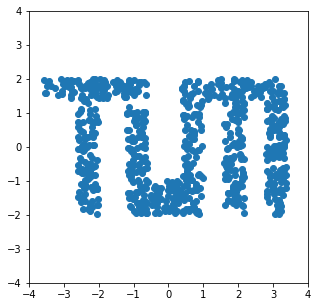

In [4]:
sample_batch = next(iter(batched_train_data))
plot_samples_2d(sample_batch)

## 2. Build the Normalizing Flow
The next step is to build the respective normalizing flow. In this example the Masked Autogregressive Flow (MAF) implementation from Tensorflow is used. The documentation can be found here [1]. Other flows can be imported from "normalizingflows/flow_catalog.py". In Tensorflow several layers of normalizing flows are chained with the "tfb.Chain" function [2]. For flows that use coupling transformations, e.g. Real NVP, Neural Spline Flow, and MAF, it is recommended to use permutation between the layers of the flow. Batch normalization, which is also implemented in the "flow_catalog.py" file, improves the results on high dimensional datasets such as image data. 
The normalzing flow is created by inputting the chained bijector with all layers a base distribution, which is usually a Gaussian distribution, into the "tfd.TransformedDistribution" [3].

[1]: https://www.tensorflow.org/probability/api_docs/python/tfp/bijectors/MaskedAutoregressiveFlow
[2]: https://www.tensorflow.org/probability/api_docs/python/tfp/bijectors/Chain
[3]: https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/TransformedDistribution

In [5]:
hidden_shape = [200, 200]  # hidden shape for MADE network of MAF
layers = 12  # number of layers of the flow

base_dist = tfd.Normal(loc=0.0, scale=1.0)  # specify base distribution

bijectors = []
for i in range(0, layers):
    bijectors.append(tfb.MaskedAutoregressiveFlow(shift_and_log_scale_fn = Made(params=2, hidden_units=hidden_shape, activation="relu")))
    bijectors.append(tfb.Permute(permutation=[1, 0]))  # data permutation after layers of MAF
    
bijector = tfb.Chain(bijectors=list(reversed(bijectors)), name='chain_of_maf')

maf = tfd.TransformedDistribution(
    distribution=base_dist,
    bijector=bijector,
    event_shape=[2]
)

# initialize flow
samples = maf.sample()

## 3. Train the Normalizing Flow
In this example we train the flow with a polynomial learning rate decay. Afer the training, the checkpoint with the best performance on the validation set is reloaded and tested on the test dataset. Early stopping is used, if the validation loss does not decrease for "delta_stop" epochs.

In [6]:
base_lr = 1e-3
end_lr = 1e-4
max_epochs = int(5e3)  # maximum number of epochs of the training
learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(base_lr, max_epochs, end_lr, power=0.5)

In [7]:
# initialize checkpoints
checkpoint_directory = "{}/tmp_{}".format(dataset_name, str(hex(random.getrandbits(32))))
checkpoint_prefix = os.path.join(checkpoint_directory, "ckpt")

opt = tf.keras.optimizers.Adam(learning_rate=learning_rate_fn)  # optimizer
checkpoint = tf.train.Checkpoint(optimizer=opt, model=maf)

0, train_loss: 4.286161422729492, val_loss: 3.9576032161712646
100, train_loss: 3.154604434967041, val_loss: 3.1906023025512695
200, train_loss: 3.0383429527282715, val_loss: 3.088075637817383
300, train_loss: 3.2014269828796387, val_loss: 3.2621068954467773
400, train_loss: 3.1380889415740967, val_loss: 3.249666690826416
500, train_loss: 3.1868720054626465, val_loss: 3.2856192588806152
600, train_loss: 3.0524768829345703, val_loss: 3.1164865493774414
700, train_loss: 2.9889421463012695, val_loss: 3.1485989093780518
800, train_loss: 2.946242332458496, val_loss: 3.0438883304595947
900, train_loss: 2.928800582885742, val_loss: 3.0527451038360596
1000, train_loss: 2.912815809249878, val_loss: 3.0189034938812256
1100, train_loss: 2.9291980266571045, val_loss: 3.0313994884490967
1200, train_loss: 2.9118332862854004, val_loss: 3.0510566234588623
1300, train_loss: 2.8289029598236084, val_loss: 3.0541183948516846
1400, train_loss: 2.9370415210723877, val_loss: 3.0184619426727295
1500, train_lo

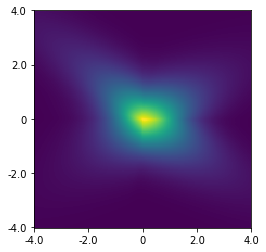

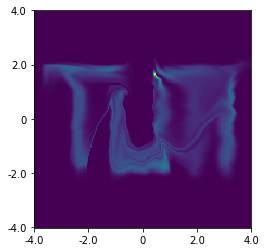

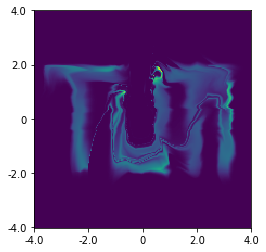

In [8]:
global_step = []
train_losses = []
val_losses = []
min_val_loss = tf.convert_to_tensor(np.inf, dtype=tf.float32)  # high value to ensure that first loss < min_loss
min_train_loss = tf.convert_to_tensor(np.inf, dtype=tf.float32)
min_val_epoch = 0
min_train_epoch = 0
delta_stop = 1000  # threshold for early stopping

t_start = time.time()  # start time

# start training
for i in range(max_epochs):
    for batch in batched_train_data:
        train_loss = train_density_estimation(maf, opt, batch)

    if i % int(100) == 0:
        val_loss = nll(maf, val_data)
        global_step.append(i)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f"{i}, train_loss: {train_loss}, val_loss: {val_loss}")

        if train_loss < min_train_loss:
            min_train_loss = train_loss
            min_train_epoch = i

        if val_loss < min_val_loss:
            min_val_loss = val_loss
            min_val_epoch = i
            checkpoint.write(file_prefix=checkpoint_prefix)  # overwrite best val model

        elif i - min_val_epoch > delta_stop:  # no decrease in min_val_loss for "delta_stop epochs"
            break

    if i % int(1000) == 0:
        # plot heatmap every 1000 epochs
        plot_heatmap_2d(maf, -4.0, 4.0, -4.0, 4.0, mesh_count=200)

train_time = time.time() - t_start

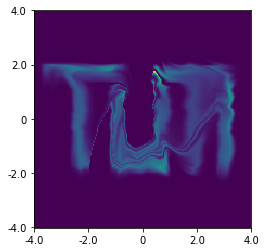

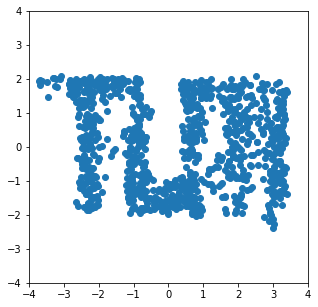

In [9]:
# load best model with min validation loss
checkpoint.restore(checkpoint_prefix)

# perform on test dataset
t_start = time.time()
test_loss = nll(maf, test_data)
test_time = time.time() - t_start

# plot density estimation of the best model
plot_heatmap_2d(maf, -4.0, 4.0, -4.0, 4.0, mesh_count=200, name=None)  # to save the image, specify a directory as name

# plot samples of the best model
plot_samples_2d(maf.sample(1000), name=None)  # to save the image, specify a directory as name

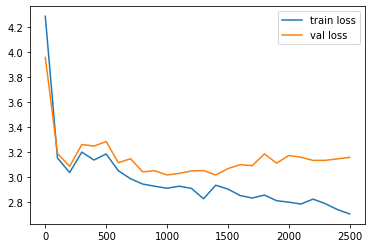

In [10]:
# plot train and validation loss curve
plt.plot(global_step, train_losses, label="train loss")
plt.plot(global_step, val_losses, label="val loss")
plt.legend()

## 4. Sanity Check
On 2D toy data, a sanity check can be performed. The sanity check approximates the integral of the probability density function on the specified area. The approxmiated integral should be close to 1.

In [11]:
integral = sanity_check(maf, xmin=-4.0, xmax=4.0, ymin=-4.0, ymax=4.0, mesh_count=250)
print(integral)

tf.Tensor(0.9913172, shape=(), dtype=float32)


## 5. Delete unnecessary checkpoints

In [12]:
filelist = [f for f in os.listdir(checkpoint_directory)]
for f in filelist:
    os.remove(os.path.join(checkpoint_directory, f))
os.removedirs(checkpoint_directory)